<a href="https://colab.research.google.com/github/duphlot/soICT/blob/main/notebooks/automatic_mask_generator_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Automatically generating object masks with SAM

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B.

The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [ ]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [ ]:
using_colab = True

In [ ]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.8.0+cu126
Torchvision version: 0.23.0+cu126
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-wfmbf0p1
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-wfmbf0p1
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=5918e9422979ff9ef5901941a9eed2b4abc2203c7f2daa4c3b8685b9211d4f75
  Stored in directory: /tmp/pip-ephem-wheel-cache-oj39wkh7/wheels/29/82/ff/04e2be9805a1cb48bec0b85b5a6da6b63f647645750a0e42d4
Successfully built segment_anything
--2025-09-14 12:35:00--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com

## Set-up

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

## Example image

In [ ]:
image = cv2.imread('/content/images/dog.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

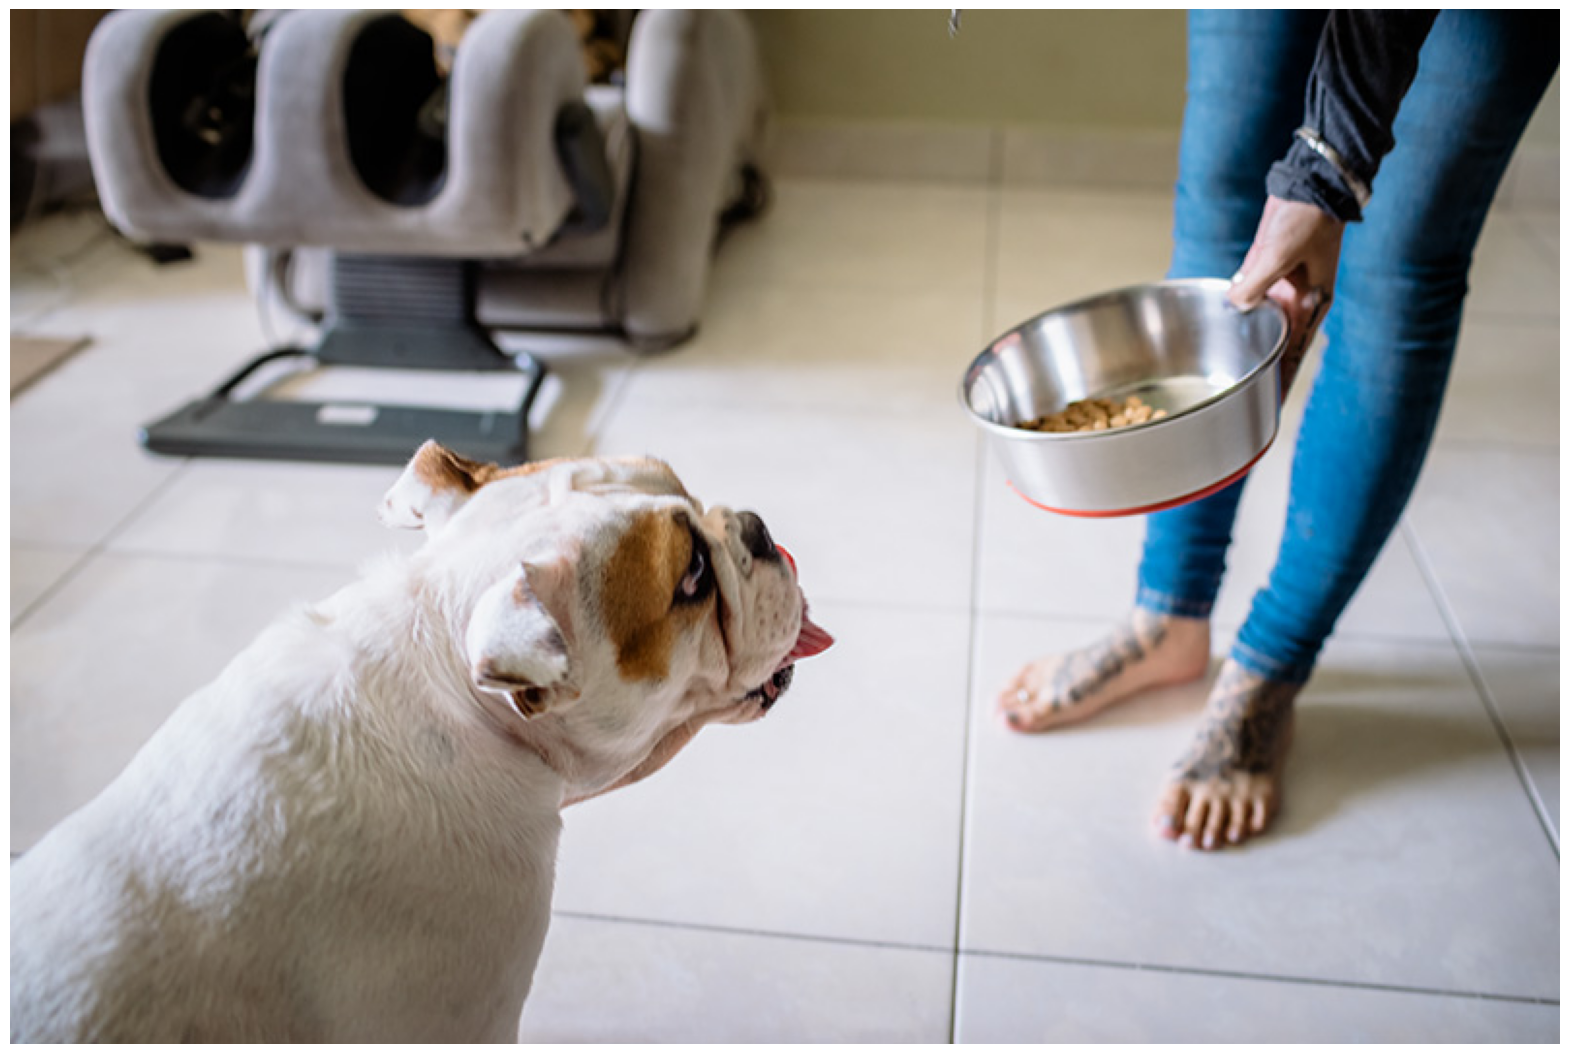

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

To generate masks, just run `generate` on an image.

In [ ]:
masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [ ]:
print(len(masks))
print(masks[0].keys())

66
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


Show all the masks overlayed on the image.

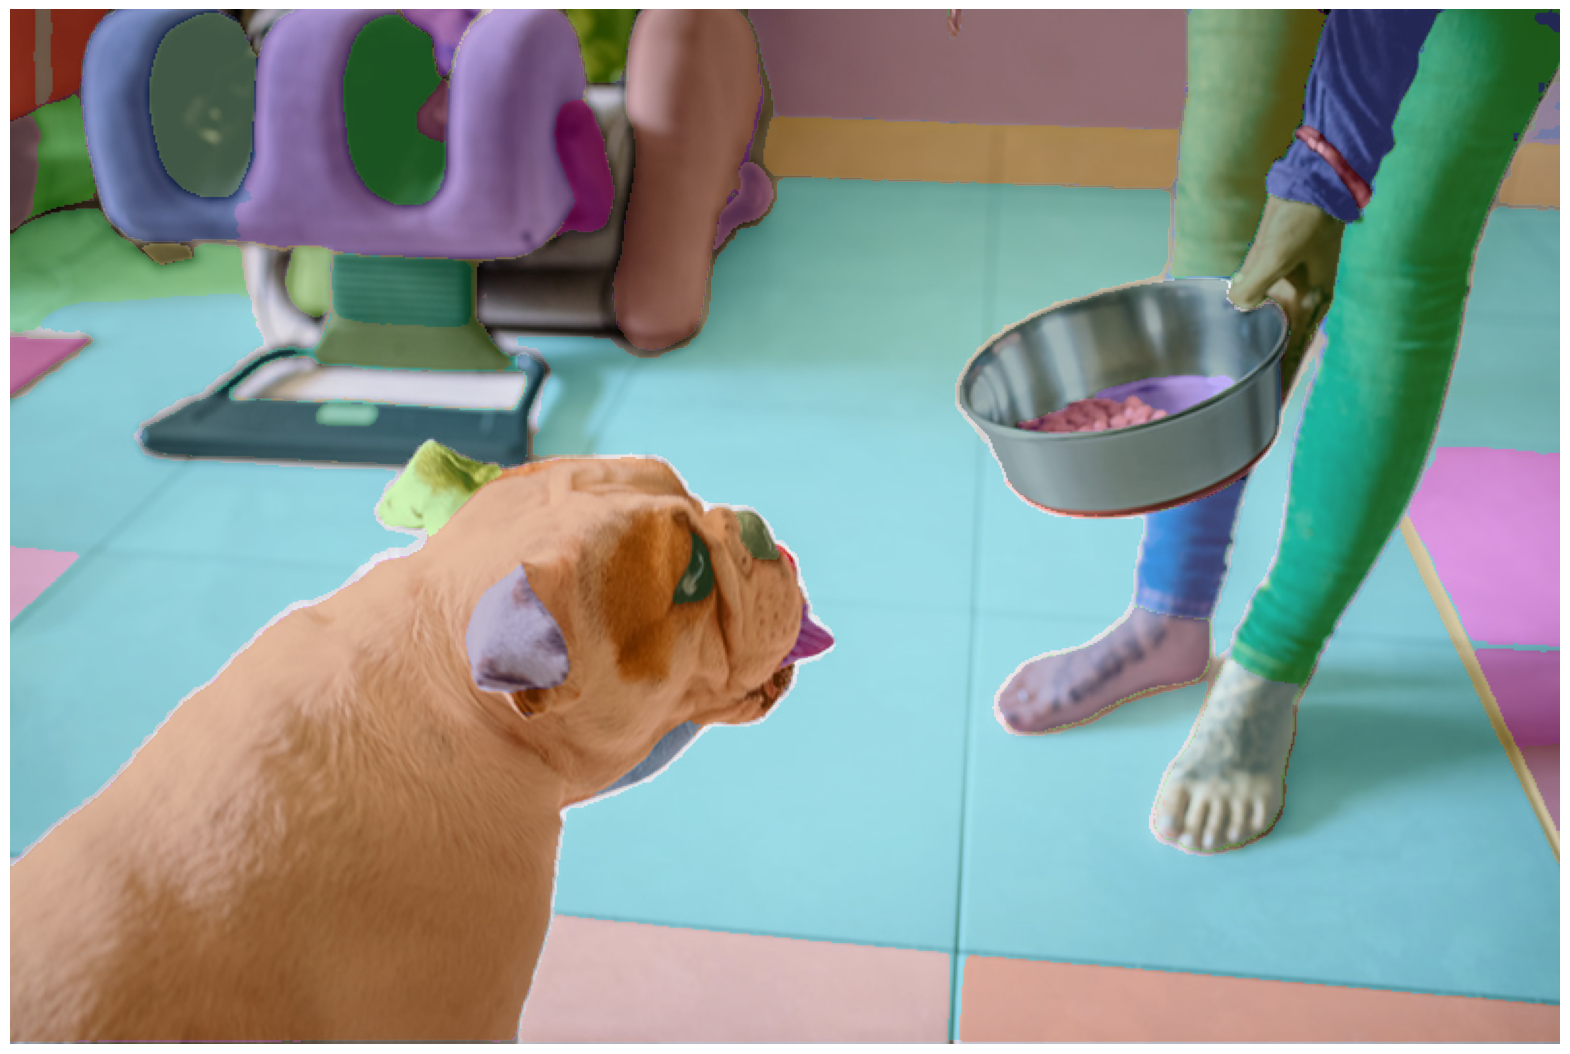

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [ ]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [ ]:
masks2 = mask_generator_2.generate(image)

In [ ]:
len(masks2)

90

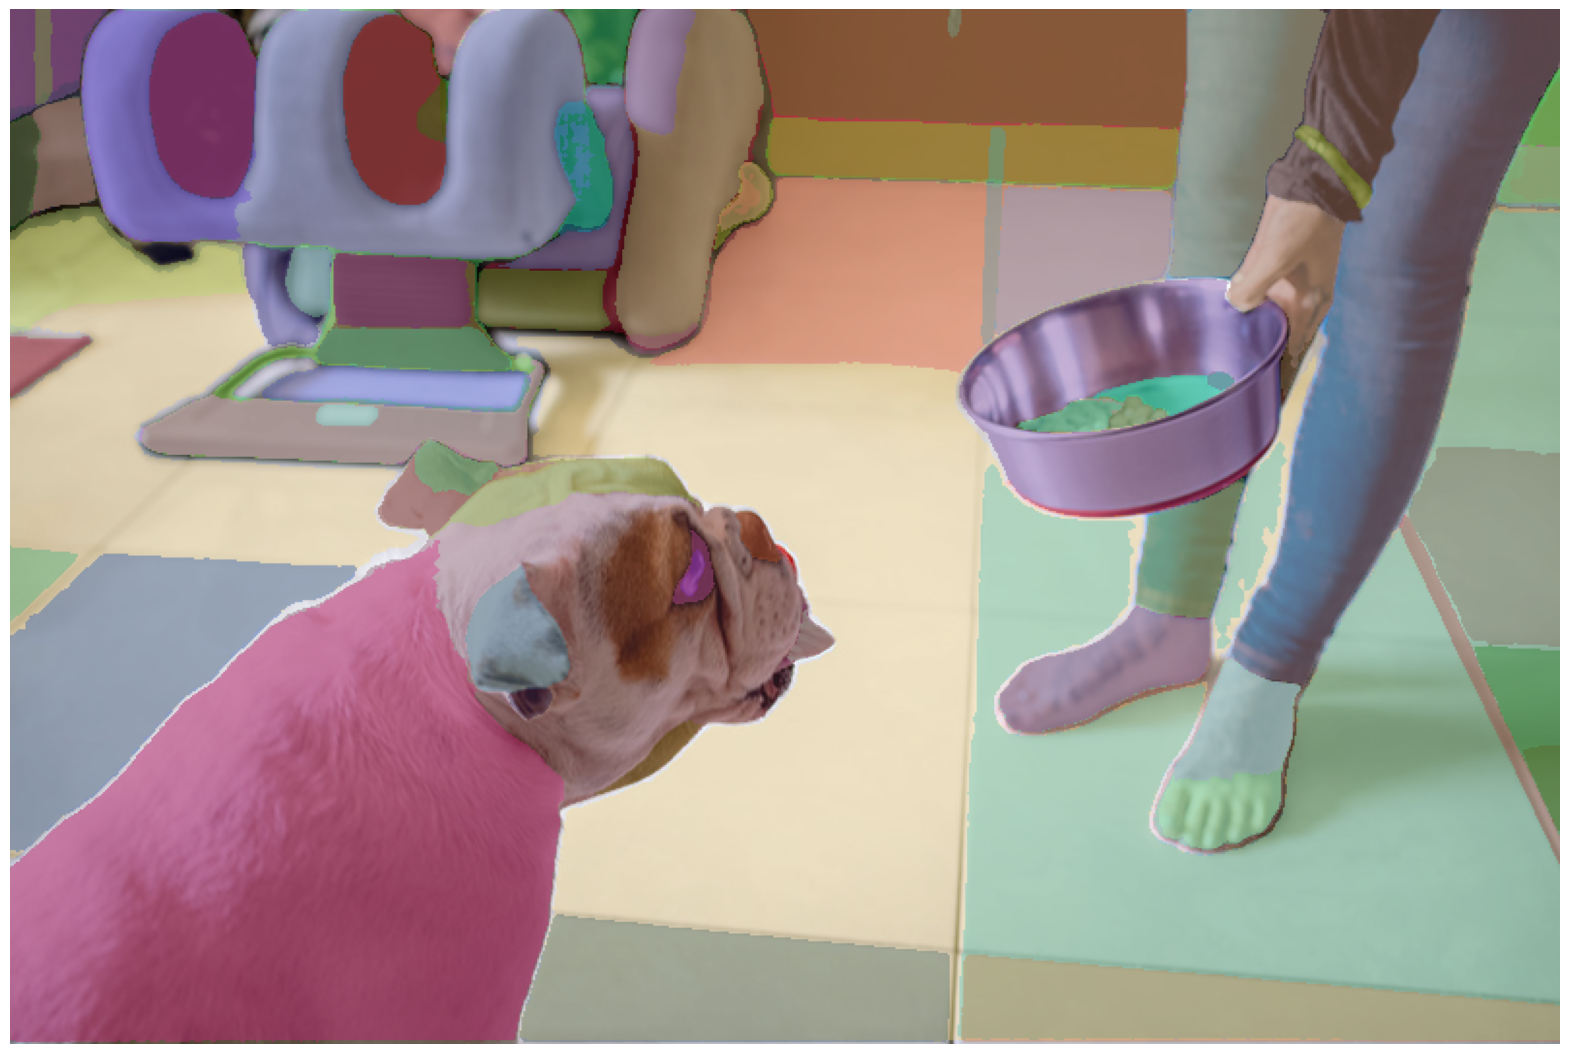

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show()

In [ ]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-ecy3iv3f
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-ecy3iv3f
  Resolved https://github.com/facebookresearch/detectron2.git to commit a1ce2f956a1d2212ad672e3c47d53405c2fe4312
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 72.2 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp312-cp312-linux_x86_64.whl size=6733317 sha256=1511fe208c470595cde256d8392770a8b260420afe509994de92a734e892bbeb
  Stored in directory: /tmp/pip-ephem-wheel-cache-q13ntk2u/wheels/d3/6e/bd/1969578f1456a6be

In [ ]:
import cv2, torch, numpy as np
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# --- Load SAM ---
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
mask_generator = SamAutomaticMaskGenerator(sam)

# --- Load Detectron2 panoptic model ---
cfg = get_cfg()
from detectron2 import model_zoo

cfg.merge_from_file(model_zoo.get_config_file(
    "COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"
))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"
)

# cfg.merge_from_file("configs/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
# cfg.MODEL.WEIGHTS = "detectron2://COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/13951456/model_final_c10459.pkl"
cfg.MODEL.DEVICE = device
predictor = DefaultPredictor(cfg)

# --- Utility ---
def iou(mask1, mask2):
    inter = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return inter / union if union > 0 else 0

# --- Run on one frame ---
frame = cv2.imread("/content/01.jpeg")

# Panoptic prediction
outputs = predictor(frame)
panoptic_seg, segments_info = outputs["panoptic_seg"]
panoptic_seg = panoptic_seg.cpu().numpy()

# SAM prediction
sam_masks = mask_generator.generate(frame)
sam_masks = [m["segmentation"] for m in sam_masks]

# Refine masks
refined_masks = []
for seg in segments_info:
    seg_id = seg["id"]
    mask_pan = (panoptic_seg == seg_id)

    best_iou, best_sam = 0, None
    for sam_m in sam_masks:
        score = iou(mask_pan, sam_m)
        if score > best_iou:
            best_iou, best_sam = score, sam_m

    if best_iou > 0.5:
        mask_final = best_sam  # dùng biên từ SAM
    else:
        mask_final = mask_pan  # giữ nguyên

    refined_masks.append({
        "category_id": seg["category_id"],
        "isthing": seg["isthing"],
        "mask": mask_final
    })


model_final_cafdb1.pkl: 261MB [00:14, 17.5MB/s]                           
/usr/local/lib/python3.12/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
outputs = predictor(frame)
panoptic_seg, segments_info = outputs["panoptic_seg"]


In [ ]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

v = Visualizer(frame[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]))
out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)

cv2.imwrite("panoptic_result.jpg", out.get_image()[:, :, ::-1])


True

In [ ]:
import json
import numpy as np
from pycocotools import mask as mask_utils
from detectron2.data import MetadataCatalog

# lấy metadata từ Detectron2 panoptic model
metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
thing_classes = metadata.thing_classes
stuff_classes = metadata.stuff_classes

json_results = []

for obj in refined_masks:
    # encode mask sang RLE
    rle = mask_utils.encode(
        np.asfortranarray(obj["mask"].astype(np.uint8))
    )
    rle["counts"] = rle["counts"].decode("utf-8")

    cat_id = int(obj["category_id"])
    if obj["isthing"]:
        cat_name = thing_classes[cat_id]
    else:
        cat_name = stuff_classes[cat_id]

    json_results.append({
        "category_id": cat_id,
        "category_name": cat_name,
        "isthing": bool(obj["isthing"]),
        "segmentation": rle
    })

with open("results.json", "w") as f:
    json.dump(json_results, f, indent=2)


In [ ]:
!pip install py_vncorenlp
!wget https://github.com/vncorenlp/VnCoreNLP/archive/refs/tags/v1.1.1.zip
!unzip v1.1.1.zip
!mv VnCoreNLP-1.1.1/VnCoreNLP-1.1.1.jar ./VnCoreNLP-1.1.1.jar
!mv VnCoreNLP-1.1.1/models ./models

--2025-09-17 09:09:15--  https://github.com/vncorenlp/VnCoreNLP/archive/refs/tags/v1.1.1.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/vncorenlp/VnCoreNLP/zip/refs/tags/v1.1.1 [following]
--2025-09-17 09:09:15--  https://codeload.github.com/vncorenlp/VnCoreNLP/zip/refs/tags/v1.1.1
Resolving codeload.github.com (codeload.github.com)... 140.82.113.10
Connecting to codeload.github.com (codeload.github.com)|140.82.113.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘v1.1.1.zip.1’

v1.1.1.zip.1            [              <=>   ] 137.29M  22.1MB/s    in 6.2s    

2025-09-17 09:09:21 (22.1 MB/s) - ‘v1.1.1.zip.1’ saved [143955573]

Archive:  v1.1.1.zip
3b5c2aac53bb1fda0502d89ab8085b712e299fab
replace VnCoreNLP-1.1.1/LICENSE.md? [y]es, [n]o, [A]ll, [N]one, [r]enam

In [ ]:
!mv /content/VnCoreNLP-1.1.1.jar /content/VnCoreNLP-1.2.jar

In [ ]:
import py_vncorenlp

rdrsegmenter = py_vncorenlp.VnCoreNLP(
    annotators=["wseg", "pos", "ner", "dep"],
    save_dir='/content'
)

text = "Anh Nam đang đọc sách ở Hà Nội."
dep = rdrsegmenter.dependency_parse(text)
print(dep)
